In [7]:
import os
from glob import glob
from torchvision import transforms, utils
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode
from torch.utils.data import Dataset
import numpy as np
import torch

import albumentations as A 
import albumentations.pytorch as apy

In [26]:
class nuclei_dataset(Dataset):

    def __init__(self, data_dir, mode='train', image_size=224, one_hot=True, transform=None, train_split=0.7, val_split=0.1):
        self.data_dir = data_dir
        self.transform = transform
        self.one_hot = one_hot
        self.image_size = image_size
        
        self.data_dirs = glob(os.path.join(self.data_dir, "*/"))

        self.train_split = train_split
        self.val_split = val_split

        # split the dataset
        n = len(self.data_dirs)
        n_train, n_val = int(self.train_split * n), int(self.val_split * n)

        if mode == "train":
            self.data_dirs = self.data_dirs[:n_train]
        elif mode == "val":
            self.data_dirs = self.data_dirs[n_train:n_train+n_val]
        elif mode == "test":
            self.data_dirs = self.data_dirs[n_train+n_val:]

        if self.transform is None:
            self.transform = A.Compose([
                A.Resize(self.image_size, self.image_size),
            ])


    def __len__(self):
        return len(self.data_dirs)

    def __getitem__(self, idx):
        data_at_idx = self.data_dirs[idx]
        data_name = data_at_idx.split("/")[-2]

        xp = glob(os.path.join(data_at_idx, "images/*.png"))[0]
        yp = glob(os.path.join(data_at_idx, "masks/*.png"))

        image = read_image(xp, ImageReadMode.RGB)
        
        masks = torch.zeros(len(yp), image.shape[1], image.shape[2])

        for i, y in enumerate(yp):
            mask_ = read_image(y, ImageReadMode.GRAY)
            masks[i, :, :] = mask_
        
        masks = masks.to(torch.int64)
        mask = torch.amax(masks, dim=0)

        if not self.transform:
            im = np.transpose(image.numpy(), (1,2,0))
            
            msk = np.transpose(masks.numpy(), (1,2,0))
            
            augmented = self.transform(image=im, mask=msk)
            image = torch.from_numpy(augmented['image'])
            masks = torch.from_numpy(augmented['mask']).to(torch.float)

            image = np.transpose(image, (2, 0, 1))
            masks = np.transpose(masks, (2, 0, 1))
        
        if self.one_hot:
            return {'image': image, 'mask': masks}
        else:
            mask = torch.amax(masks, dim=0).to(torch.float)
            return {'image': image, 'mask': mask}
            

In [27]:
data_path = "../../datasets/data-science-bowl-2018/stage1_train/"

transform = A.Compose([
    A.Resize(256, 256),
    #A.HorizontalFlip(p=0.5),
    #A.VerticalFlip(p=0.5),
])


In [28]:
train_dataset = nuclei_dataset(data_path, one_hot=True)


In [29]:
for i in range(len(train_dataset)):
    data = train_dataset[i]
    print(data['image'].shape, data['mask'].shape)

torch.Size([3, 360, 360]) torch.Size([25, 360, 360])
torch.Size([3, 256, 256]) torch.Size([6, 256, 256])
torch.Size([3, 256, 256]) torch.Size([51, 256, 256])
torch.Size([3, 256, 256]) torch.Size([14, 256, 256])
torch.Size([3, 256, 320]) torch.Size([111, 256, 320])
torch.Size([3, 256, 320]) torch.Size([37, 256, 320])
torch.Size([3, 256, 256]) torch.Size([49, 256, 256])
torch.Size([3, 360, 360]) torch.Size([12, 360, 360])
torch.Size([3, 256, 256]) torch.Size([77, 256, 256])
torch.Size([3, 256, 320]) torch.Size([59, 256, 320])
torch.Size([3, 360, 360]) torch.Size([27, 360, 360])
torch.Size([3, 256, 256]) torch.Size([46, 256, 256])
torch.Size([3, 256, 256]) torch.Size([19, 256, 256])
torch.Size([3, 256, 320]) torch.Size([11, 256, 320])
torch.Size([3, 256, 256]) torch.Size([10, 256, 256])
torch.Size([3, 520, 696]) torch.Size([61, 520, 696])
torch.Size([3, 256, 256]) torch.Size([16, 256, 256])
torch.Size([3, 256, 256]) torch.Size([7, 256, 256])
torch.Size([3, 520, 696]) torch.Size([32, 520, 

KeyboardInterrupt: 

In [12]:
import matplotlib.pyplot as plt

def show_image_and_mask(im1, im2, figsize=[8,4], im1_title='Image', im2_title='Mask', show=True):

    if im1.shape[0] < 4:
        im1 = np.array(im1)
        im1 = np.transpose(im1, (1,2,0))

    if im2.shape[0] < 4:
        im2 = np.array(im2)
        im2 = np.transpose(im2, (1,2,0))
        rows, cols = 1, 2
    else:
        if len(im2.size()) == 3:
            rows, cols = im2.shape[0], 2
        else:
            rows, cols = 1,2
            
    _, ax = plt.subplots(rows, cols, figsize=[8, 4*rows])

    if rows == 1:
        ax[0].imshow(im1)
        ax[0].set_title(im1_title)
        ax[1].imshow(im2, cmap='gray')
        ax[1].set_title(im2_title)
    else:
        for i in range(0, im2.shape[0]):
            ax[i, 0].imshow(im1)
            ax[i,0].set_title(im1_title)
            ax[i, 1].imshow(im2[i,:,:], cmap='gray')
            ax[i, 1].set_title(im2_title)
        
    if show:
        plt.show()

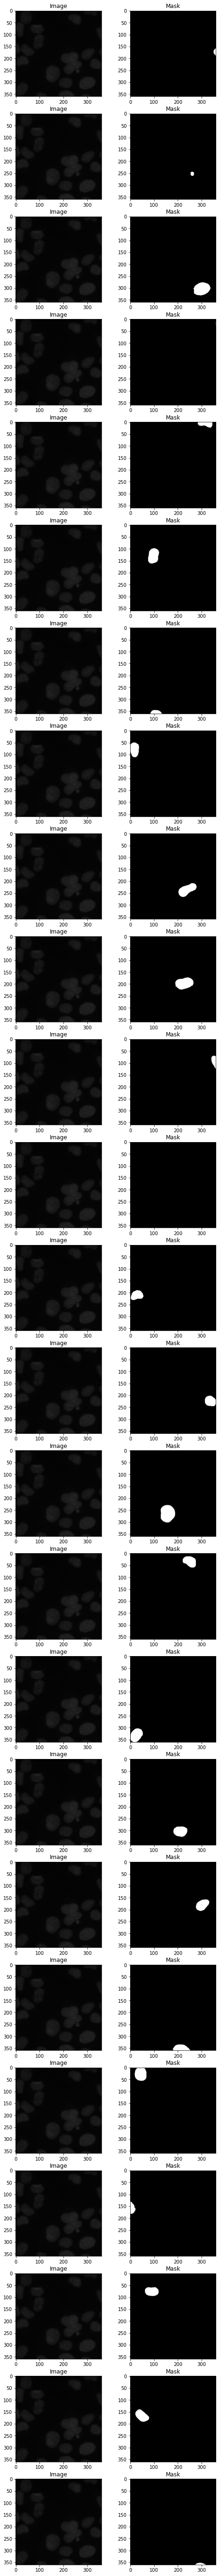

In [13]:
import sys
sys.path.append('..')
from utils import show_image_and_mask

show_image_and_mask(data['image'], data['mask'])